In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, pathlib
sys.path.insert(0, os.path.abspath("../.."))

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from PIL import Image

from config import IN_DEVELOPMENT
from config import DATA_DIR, SOURCE_IMAGES_DIR, POST_EVENT_ORIGINAL_TILES_TIF_DIR, POST_EVENT_CONVERTED_TILES_TIF_DIR, BUILDING_FOOTPRINTS_DIR
from config import TILE_DIMENSIONS, NUM_SAMPLE_TILES
from utils import visualize_geotiff, sample_random_tile_from_tif, convert_tif_crs_to_shapefile_crs
from utils import get_corners_from_tif_in_certain_crs, get_points_from_bounds, get_buildings_in_polygon
from utils import get_image_array, get_transposed_image_data
from utils import rasterize

In [2]:
shapefile = gpd.read_file(BUILDING_FOOTPRINTS_DIR)
shapefile_crs = shapefile.crs

In [3]:
post_event_source_image = SOURCE_IMAGES_DIR / "Post_Event_San_Juan.tif"
post_event_source_image

PosixPath('/home/gautam/Documents/Competitions/eye-for-detail/data/source_images/Post_Event_San_Juan.tif')

In [264]:
np.random.seed(0)

In [265]:
tile_path = sample_random_tile_from_tif(sample_idx=0, input_file=post_event_source_image, output_dir=POST_EVENT_ORIGINAL_TILES_TIF_DIR,
                                tile_height=TILE_DIMENSIONS, tile_width=TILE_DIMENSIONS)
tile_path

Tiles generation completed.


PosixPath('/home/gautam/Documents/Competitions/eye-for-detail/data/tiles/Post_Event_Grids_In_TIF/0_tile.tif')

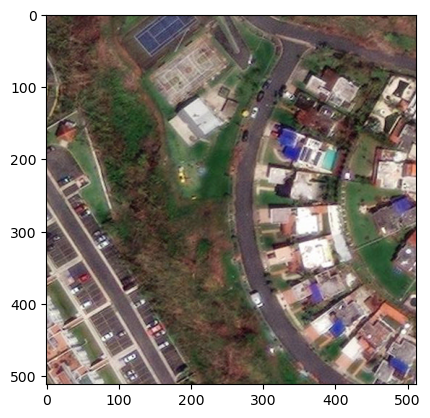

In [266]:
visualize_geotiff(tile_path)

In [267]:
converted_tile_path = convert_tif_crs_to_shapefile_crs(input_tif=tile_path, output_dir=POST_EVENT_CONVERTED_TILES_TIF_DIR, dest_crs=shapefile_crs)
converted_tile_path

PosixPath('/home/gautam/Documents/Competitions/eye-for-detail/data/tiles/Post_Event_Converted_Grids_In_TIF/0_tile_converted.tif')

In [268]:
corner_coordinates = get_corners_from_tif_in_certain_crs(input_tif=converted_tile_path, tile_width=TILE_DIMENSIONS)
corner_coordinates

(163416.08392746845, 2032975.2213089266, 163572.38155287612, 2032818.923683519)

In [269]:
four_corner_coords = get_points_from_bounds(*corner_coordinates)
four_corner_coords

[(163416.08392746845, 2032975.2213089266),
 (163572.38155287612, 2032975.2213089266),
 (163572.38155287612, 2032818.923683519),
 (163416.08392746845, 2032818.923683519)]

In [270]:
building_footprints_in_tile = get_buildings_in_polygon(shapefile=shapefile, corner_coords=four_corner_coords)
building_footprints_in_tile.head()

,latitude,longitude,area_in_me,confidence,full_plus_,geometry
6181,18.358966,-66.183541,None,0.8167,77CM9R58+HHPP,"POLYGON ((163536.953 2032848.813, 163533.217 2..."
11849,18.358979,-66.183807,None,0.8231,77CM9R58+HFW2,"POLYGON ((163497.409 2032852.244, 163508.416 2..."
19571,18.359778,-66.183262,None,0.7136,77CM9R58+WM94,"POLYGON ((163566.546 2032939.715, 163561.812 2..."
37898,18.359138,-66.183954,None,0.7695,77CM9R58+MC3F,"POLYGON ((163493.561 2032863.122, 163482.894 2..."
38932,18.359004,-66.184345,None,0.8269,77CM9R58+J725,"POLYGON ((163452.373 2032850.423, 163442.982 2..."


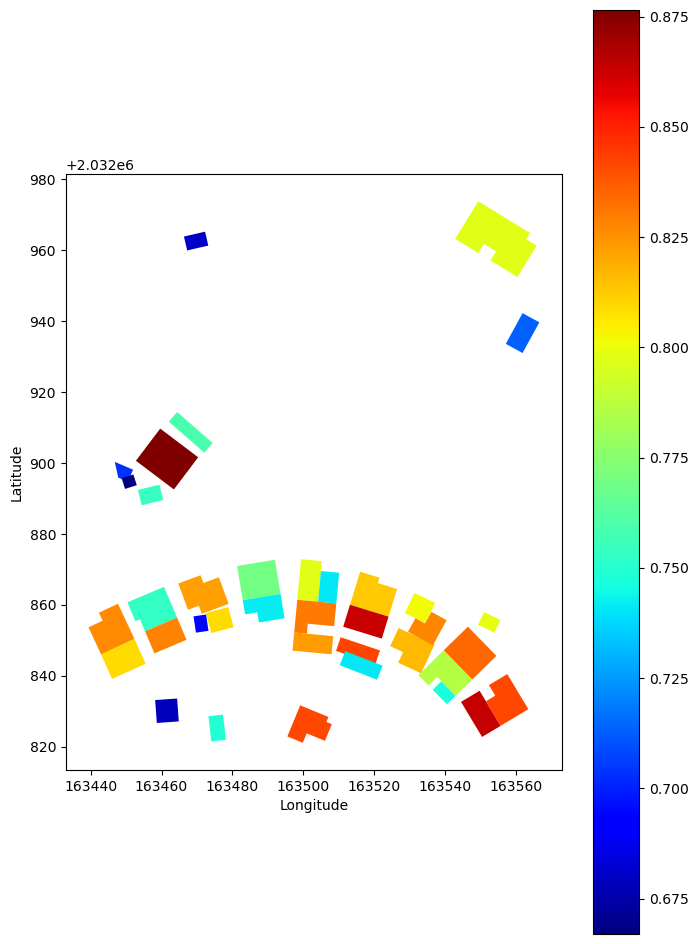

In [271]:
fig, ax = plt.subplots(1, figsize=(8, 12))
building_footprints_in_tile.plot(ax=ax, column="confidence", cmap="jet", legend=True)
# shapefile.plot(ax=ax, cmap="jet", legend=True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

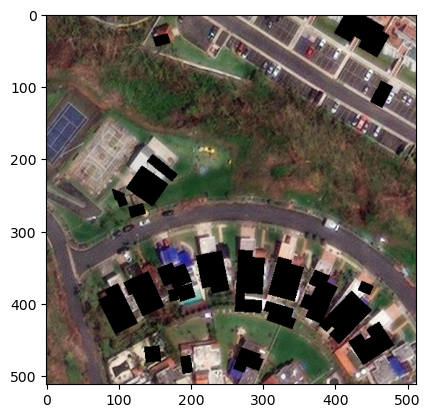

In [272]:
transposed_image = get_transposed_image_data(input_tif=tile_path)

rasterized_footprints = rasterize(raster_path=tile_path, shapefile=building_footprints_in_tile)

transposed_image[rasterized_footprints != 0] = 0
plt.imshow(transposed_image)
plt.show()

In [273]:
labelme_json = {
    "version": "5.4.1",
    "flags": {},
    "imagePath": "0_tile.tif",
    "imageData": None,
    "imageHeight": 512,
    "imageWidth": 512
}

In [274]:
from osgeo import gdal

In [275]:
gt = gdal.Open(converted_tile_path).GetGeoTransform()
gt

(163416.08392746845,
 0.30526879962434383,
 0.0,
 2032975.2213089266,
 0.0,
 -0.30526879962434383)

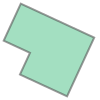

In [276]:
geom = building_footprints_in_tile.iloc[0]["geometry"]
geom

In [277]:
geom.bounds

(163524.49072740227,
 2032840.7314095064,
 163536.95300386014,
 2032853.4855358375)

In [278]:
building_coords = np.array(list(geom.exterior.coords))
building_coords

array([[ 163536.95300386, 2032848.81269219],
       [ 163533.21654451, 2032840.73140951],
       [ 163526.72981381, 2032843.73061194],
       [ 163528.1105069 , 2032846.71680026],
       [ 163524.4907274 , 2032848.39044057],
       [ 163526.84649465, 2032853.48553584],
       [ 163536.95300386, 2032848.81269219]])

In [279]:
pixel_coords = np.zeros_like(building_coords)
pixel_coords

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [280]:
pixel_coords[:, 0] = (building_coords[:, 0] - gt[0]) / gt[1]
pixel_coords[:, 1] = (building_coords[:, 1] - gt[3]) / gt[5]
pixel_coords

array([[395.94310503, 414.08953977],
       [383.70320578, 440.56221791],
       [362.45396346, 430.73742598],
       [366.97683999, 420.95526574],
       [355.11916078, 415.47275227],
       [362.83618673, 398.78223139],
       [395.94310503, 414.08953977]])

In [281]:
def convert_coords_pixel_coords(polygon, geotransform):
    bounds = polygon.bounds
    # building_coords = np.array(list(polygon.exterior.coords))
    building_coords = np.array(get_points_from_bounds(*bounds))
    pixel_coords = np.zeros_like(building_coords)
    pixel_coords[:, 0] = (building_coords[:, 0] - geotransform[0]) / geotransform[1]
    pixel_coords[:, 1] = (building_coords[:, 1] - geotransform[3]) / geotransform[5]
    return pixel_coords

In [282]:
def convert_all_coords_pixel_coords(gdf, converted_tile_path):
    gt = gdal.Open(converted_tile_path).GetGeoTransform()
    def apply_conversion(row):
        return convert_coords_pixel_coords(row["geometry"], gt)
    return gdf.apply(apply_conversion, axis=1)

In [283]:
pixel_coords = convert_all_coords_pixel_coords(building_footprints_in_tile, converted_tile_path)

In [284]:
pixel_coords.iloc[0].tolist()

[[355.1191607763964, 440.56221790657725],
 [395.9431050288156, 440.56221790657725],
 [395.9431050288156, 398.7822313938208],
 [355.1191607763964, 398.7822313938208]]

In [285]:
def create_label_shape_dict(pixel_coords):
    labelme_dict = {
        "label": "unlabeled",
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None,
        "points": pixel_coords.tolist()
    }
    return labelme_dict    

In [286]:
def get_all_labelme_shapes(gdf, converted_tile_path):
    pixel_coords = convert_all_coords_pixel_coords(gdf, converted_tile_path)
    shapes = [
        create_label_shape_dict(coords) for coords in pixel_coords
    ]
    return shapes
    

In [287]:
get_all_labelme_shapes(building_footprints_in_tile, converted_tile_path)

[{'label': 'unlabeled',
  'group_id': None,
  'description': '',
  'shape_type': 'polygon',
  'flags': {},
  'mask': None,
  'points': [[355.1191607763964, 440.56221790657725],
   [395.9431050288156, 440.56221790657725],
   [395.9431050288156, 398.7822313938208],
   [355.1191607763964, 398.7822313938208]]},
 {'label': 'unlabeled',
  'group_id': None,
  'description': '',
  'shape_type': 'polygon',
  'flags': {},
  'mask': None,
  'points': [[264.8285576040514, 422.989528746753],
   [302.46213020209245, 422.989528746753],
   [302.46213020209245, 402.8485544221761],
   [264.8285576040514, 402.8485544221761]]},
 {'label': 'unlabeled',
  'group_id': None,
  'description': '',
  'shape_type': 'polygon',
  'flags': {},
  'mask': None,
  'points': [[461.8567262817914, 144.6644004704899],
   [492.8851835742371, 144.6644004704899],
   [492.8851835742371, 107.82360633820117],
   [461.8567262817914, 107.82360633820117]]},
 {'label': 'unlabeled',
  'group_id': None,
  'description': '',
  'shape_t

In [288]:
import json

In [289]:
def create_labelme_json(building_footprints_in_tile, converted_tile_path, output_file_path):
    labelme_json = {
    "version": "5.4.1",
    "flags": {},
    "imagePath": "0_tile.tif",
    "imageData": None,
    "imageHeight": 512,
    "imageWidth": 512,
    "shapes": get_all_labelme_shapes(building_footprints_in_tile, converted_tile_path)
    }
    json.dump(labelme_json, open(output_file_path, "w+"), indent=4)

In [290]:
create_labelme_json(building_footprints_in_tile, converted_tile_path, "./../../data/tiles/Post_Event_Grids_In_TIF/0_tile.json")

In [291]:
!labelme --nodata "./../../data/tiles/Post_Event_Grids_In_TIF/"

5854.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2024-03-03 18:42:03,218 [INFO   ] __init__:get_config:67- Loading config file from: /home/gautam/.labelmerc
